In [1]:
%matplotlib inline
import data_reader

#exp = 'HEM_exp_1'
exp = 'HEM_exp_2'

dr = data_reader.DataReader()
choices, dynamics = dr.get_data(path='../../data/%s/processed/' % (exp))

First, we plot psychometric functions for CoM and no-CoM trials (aggregated over all participants)

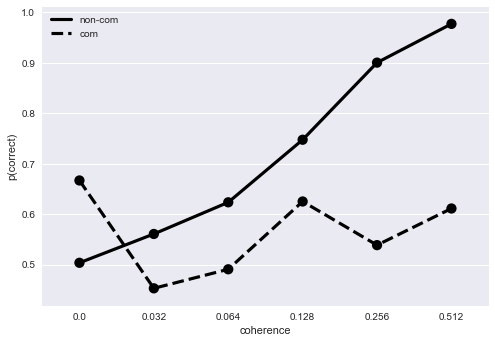

In [2]:
#from __future__ import division
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_psychometric_function(c):
    return [len(c[(c.is_correct) & (c.coherence==coherence)])/len(c[c.coherence==coherence]) \
                 for coherence in np.sort(c.coherence.unique())]
    
def plot_com_accuracy(choices, color):
    coherences = np.sort(choices.coherence.unique())
    p_correct_non_com = get_psychometric_function(choices[~choices.is_com])
    p_correct_com = get_psychometric_function(choices[choices.is_com])
    
    ax = sns.pointplot(x=coherences, y=p_correct_non_com, color=color)
    sns.pointplot(x=coherences[:len(p_correct_com)], y=p_correct_com, color=color, linestyles=['--'])
    ax.set(xlabel='coherence', ylabel='p(correct)')
    ax.legend(handles=ax.lines[::len(coherences)+1], labels=['non-com','com'])    
    
    return ax
   
plot_com_accuracy(choices, color='k')
plt.savefig('figures/psychometric_function_%s.png' % (exp))

Then we plot individual psychometric functions, again separately for CoM and no-Com trials

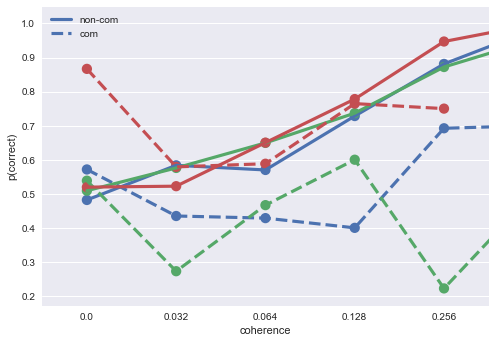

In [3]:
def plot_com_accuracy_individual(choices):
    colors = ['C0', 'C1', 'C2', 'C3']
    for i, subj_id in enumerate(choices.subj_id.unique()):
        ax = plot_com_accuracy(choices.loc[subj_id], color=colors[i])
    plt.savefig('figures/psychometric_function_individual_%s.png' % (exp))

plot_com_accuracy_individual(choices)